In [2]:
import torch
import numpy as np
from transformers import AutoProcessor, XCLIPVisionModel
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
from datasets import load_dataset
from pathlib import Path
import pandas as pd
import cv2
import albumentations as A
import numpy as np
from torchvision.transforms import RandomResizedCrop,  Compose, Normalize, ToTensor, Resize

In [18]:
data = load_dataset('TornikeO/imigue')

In [19]:
data['train'][:10]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>],
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'video': [10116,
  10116,
  10116,
  10116,
  10116,
  10116,
  10116,
  10116,
  10116,
  10116],
 'frame': [0, 11, 12, 13, 2, 3, 4, 5, 6, 7],
 'id2label': ['Turtle neck',
  'Turtle neck',
  'Turtle neck',
  'Turtle neck',
  'Turtle neck',
  'Turtle neck',
  'Turtle neck',
  

{0: 'Turtle neck', 1: 'Bulging face, deep breath', 2: 'Touching hat', 3: 'Touching or scratching head', 4: 'Touching or scratching forehead', 5: 'Covering face', 6: 'Rubbing eyes', 7: 'Touching or scratching facial parts', 8: 'Touching ears', 9: 'Biting nails', 10: 'Touching jaw', 11: 'Touching or scratching neck', 12: 'Playing with or adjusting hair', 13: 'Buckle button, pulling shirt collar, adjusting tie', 14: 'Touching or covering suprasternal notch', 15: 'Scratching back', 16: 'Folding arms', 17: 'Dustoffing clothes', 18: 'Putting arms behind body', 19: 'Moving torso', 20: 'Sitting upright', 21: 'Scratching or touching arms', 22: 'Rubbing or holding hands', 23: 'Crossing fingers', 24: 'Minaret gesture', 25: 'Playing with or manipulating objects', 26: 'Hold back arms', 27: 'Head up', 28: 'Pressing lips', 29: 'Arms akimbo', 30: 'Shaking shoulders', 31: 'Illustrative body language'}
torch.Size([3, 224, 224])


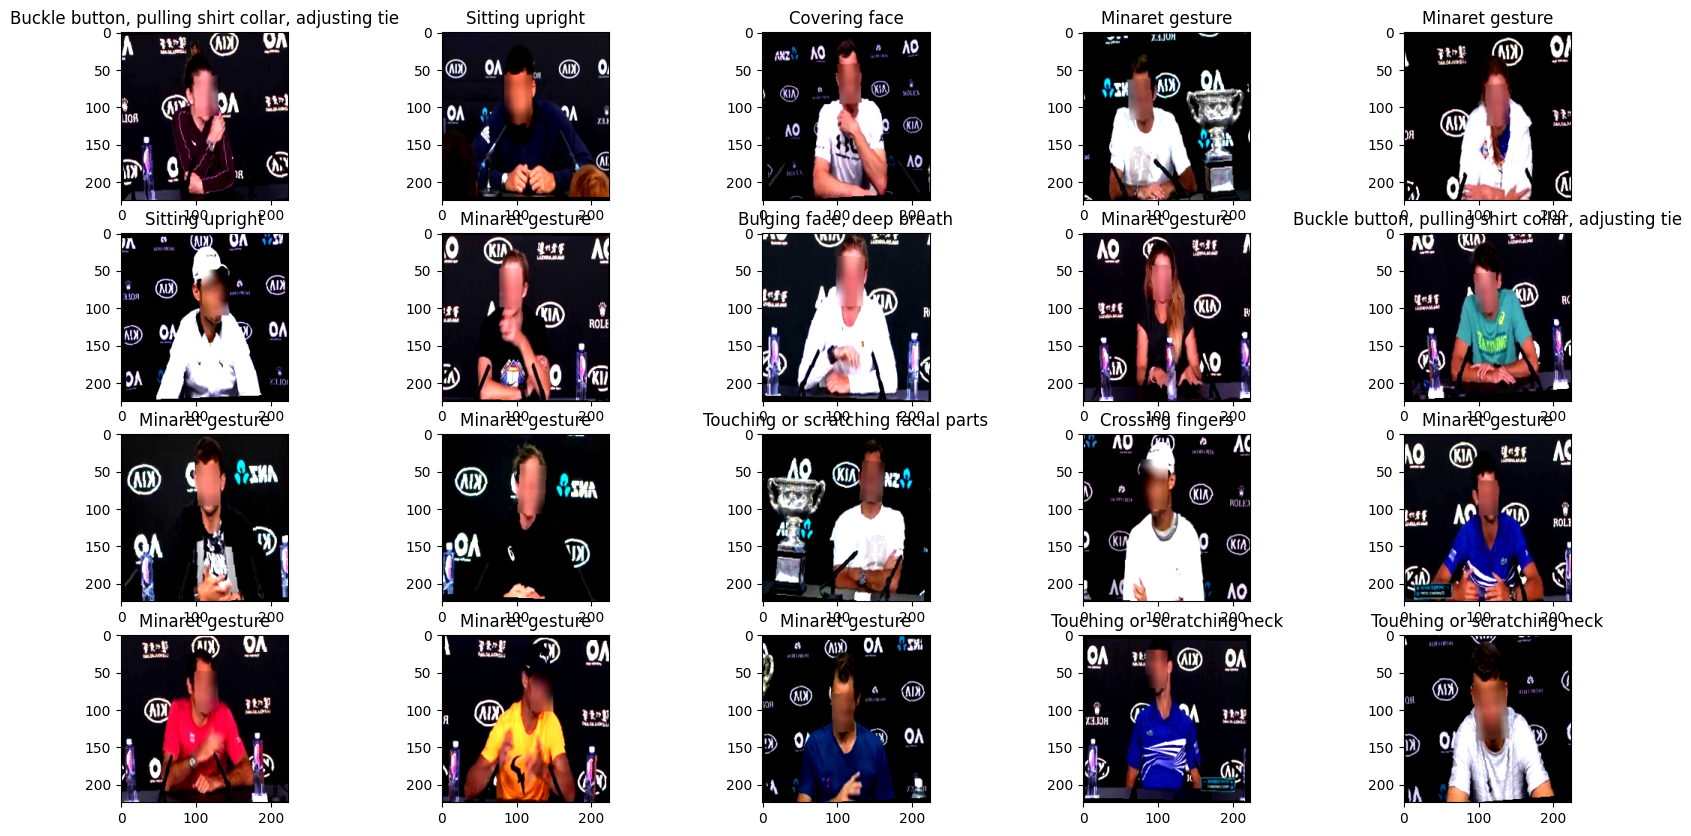

In [27]:
import torchvision.transforms as T
import cv2
import albumentations as A
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

train_transforms = T.Compose([
    T.Resize(size=size),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=5,
                   translate=(0.01, 0.03),
                   scale=(.95, 1.05),),
    T.ToTensor(),
    normalize,
])

val_transforms = T.Compose([
    T.Resize(size=size),
    T.ToTensor(),
    normalize,
])

def preprocess_train(examples):
    # print(examples)
    examples["pixel_values"] = [
        train_transforms(image) for image in examples["image"]
    ]
    examples['labels'] = [l-1 for l in examples['label']]
    del examples['image']
    del examples['label']
    return examples

def preprocess_val(examples):
    # print(examples)
    examples["pixel_values"] = [
        val_transforms(image) for image in examples["image"]
    ]
    examples['labels'] = [l-1 for l in examples['label']]
    
    del examples['image']
    del examples['label']
    return examples

names = pd.read_csv('names.csv')
names.id = names.index
label2id = dict(zip(names.id2label, names.id))
id2label = dict(zip(names.id, names.id2label))
print(id2label)

train_ds = data['train'].shuffle(42)
val_ds = data['test']
train_ds.set_transform(preprocess_train, columns=['image', 'label'], output_all_columns=False)
val_ds.set_transform(preprocess_val, columns=['image', 'label'], output_all_columns=False)

fig, axs = plt.subplots(4, 5, figsize=(20, 10))
axs = axs.ravel()
for i, (d, ax) in enumerate(zip(train_ds, axs.ravel())):
    if i == 0:
        print(d['pixel_values'].shape)
    ax.imshow((d['pixel_values'].permute(1,2,0) + .7).clip(0,1))
    ax.set_title(id2label[d['labels']])

In [7]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [8]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

{0: 'Turtle neck',
 1: 'Bulging face, deep breath',
 2: 'Touching hat',
 3: 'Touching or scratching head',
 4: 'Touching or scratching forehead',
 5: 'Covering face',
 6: 'Rubbing eyes',
 7: 'Touching or scratching facial parts',
 8: 'Touching ears',
 9: 'Biting nails',
 10: 'Touching jaw',
 11: 'Touching or scratching neck',
 12: 'Playing with or adjusting hair',
 13: 'Buckle button, pulling shirt collar, adjusting tie',
 14: 'Touching or covering suprasternal notch',
 15: 'Scratching back',
 16: 'Folding arms',
 17: 'Dustoffing clothes',
 18: 'Putting arms behind body',
 19: 'Moving torso',
 20: 'Sitting upright',
 21: 'Scratching or touching arms',
 22: 'Rubbing or holding hands',
 23: 'Crossing fingers',
 24: 'Minaret gesture',
 25: 'Playing with or manipulating objects',
 26: 'Hold back arms',
 27: 'Head up',
 28: 'Pressing lips',
 29: 'Arms akimbo',
 30: 'Shaking shoulders',
 31: 'Illustrative body language'}

In [10]:
# import pandas as pd
# df = pd.read_csv('names.csv')
# df.tail()

In [11]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    # 'google/vit-base-patch16-224'
    num_labels=len(id2label),
    # id2label=id2label,
    # label2id=label2id,
)
model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [13]:
! rm -rf model

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # return f1_metric.compute(predictions=predictions, references=labels)
    return accuracy.compute(predictions=predictions, references=labels)
  
training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    dataloader_num_workers=24,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    # seed=42,
    # fp16=False,
    # use_cpu=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Inference

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model='model/checkpoint-756', device='cuda')

In [ ]:
data = load_dataset('TornikeO/imigue',)

In [ ]:
from IPython.display import display
for i in range(0, 10_000, 500):
    sample = data['train'][i]
    sample_img = data['train'][i]['image']
    sample_class = data['train'][i]['class'] - 1 # Don't forget this!
    sample_class = id2label[sample_class]
    print('Actual class ',  sample_class)
    display(sample_img)
    pred = classifier(sample_img)
    # Predictions are pretty crap!
    print(pred)